# Cartridge case image labelling

### Important: please run `convert_3d_to_df.r` before running this to get the required .feather files


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
from glob import glob
import math
import skimage
from sklearn import linear_model

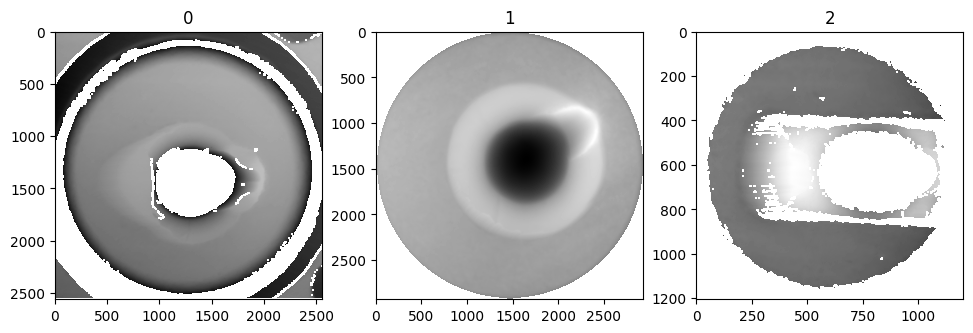

In [2]:
def display_available_images(files):
    """
    Display images from Feather files in a grid layout.

    Parameters:
    - files (list): A list of file paths to Feather files containing image data.
    """
    total_cols = 5
    total_rows = math.ceil(len(files) / total_cols)
    fig = plt.figure(figsize=(20, 10))

    for i, file in enumerate(files):
        df = pd.read_feather(file)
        df = df.pivot(index="y", columns="x", values="value").values
        fig.add_subplot(total_rows, total_cols, i + 1)
        plt.imshow(df, cmap="gray"), plt.title(i)

    plt.show()


files = glob("./data/intermediate/*.feather")
display_available_images(files)

## Change `EVALUATE` to select which image to label based on the options above


In [3]:
"""
Load data from a Feather file and process it into a pivot table.
"""
EVALUATE = 0
select_file = files[EVALUATE]
df = pd.read_feather(select_file)
df = df.pivot(index="y", columns="x", values="value").values

print(
    f"""Selected file:\t'{select_file}'
Image size:\t{df.shape}"""
)

Selected file:	'./data/intermediate\04-025.feather'
Image size:	(2562, 2557)


## Helper functions


In [4]:
def crop_evenly(arr):
    """
    Crop the input 2D NumPy array to make it square by removing equal amounts from
    its top, bottom, left, and right sides.

    Parameters:
    - arr (numpy.ndarray): The input 2D NumPy array to be cropped.

    Returns:
    - numpy.ndarray: The cropped 2D NumPy array with equal dimensions.
    """
    x, y = arr.shape
    min_dim = min(x, y)
    start_x = (x - min_dim) // 2
    start_y = (y - min_dim) // 2
    end_x = start_x + min_dim
    end_y = start_y + min_dim

    cropped_arr = arr[start_x:end_x, start_y:end_y]
    return cropped_arr


def min_max_normalization(arr):
    """
    Perform min-max normalization on a NumPy array.

    Parameters:
    - arr (numpy.ndarray): Input array to be normalized.

    Returns:
    - numpy.ndarray: Normalized array where values are scaled between 0 and 255.
    """
    min_val = np.nanmin(arr)
    max_val = np.nanmax(arr)
    normalized_arr = 255 * ((arr - min_val) / (max_val - min_val))
    return normalized_arr


def preprocess_image(df):
    """
    Preprocess a 2D array of any shape to prepare
    it for downstream image processing steps.

    Steps:
    1. Crop the image to make it square.
    2. Normalize pixel values using min-max normalization.
    3. Resize the image to 1000x1000 pixels.
    4. Handle any NaN values by setting them to 0.
    5. Convert the resulting array to uint8 data type.

    Parameters:
    - image_array (numpy.ndarray): Input 2D array representing an image.

    Returns:
    - numpy.ndarray: Preprocessed image array suitable for downstream processing.
    """
    cropped = crop_evenly(df)
    normalized = min_max_normalization(cropped)
    resized = skimage.transform.resize(normalized, (1000, 1000), mode="constant")
    resized[np.isnan(resized)] = 0
    image = resized.astype(np.uint8)
    return image


def blur_image(image):
    """
    Apply Gaussian blur to an image.

    Parameters:
    - image (numpy.ndarray): Input image to be blurred.

    Returns:
    - numpy.ndarray: Blurred image.
    """
    blur = cv2.GaussianBlur(image, (5, 5), 0)
    return blur


def binarize_image(blur):
    """
    Binarizes a blurred image using Otsu's thresholding.

    Parameters:
    - blur (numpy.ndarray): The blurred input image.

    Returns:
    - binary (numpy.ndarray): The binarized image.

    This function applies Otsu's thresholding to the input blurred image, which is often
    useful for segmenting objects from the background in scenarios like image processing
    or computer vision applications.
    """
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary


def keep_nested_contours(contours, hierarchy):
    """
    Keep only the nested contours from a list of contours based on the hierarchy.

    Parameters:
    - contours (list): List of contours.
    - hierarchy (list): Contour hierarchy as returned by OpenCV's findContours function.

    Returns:
    - list: List of relevant contours, i.e., nested contours.
    """
    relevant_contours = []

    for c, h in zip(contours, hierarchy[0]):
        if h[-1] >= 0:
            relevant_contours.append(c)

    return relevant_contours


def keep_largest_contour(contours):
    """
    Keep the largest contour from a list of contours.

    Parameters:
    - contours (list): A list of contours, where each contour is represented as an array of points.

    Returns:
    - list: A list containing the largest contour from the input list.
    """
    largest = max(contours, key=cv2.contourArea)
    return [largest]


def find_contours(image, area_threshold=0, get_largest=False, keep_nested=False):
    """
    Find contours in a binary image and filter them based on area and other options.

    Parameters:
    - image (numpy.ndarray): The input binary image.
    - area_threshold (float, optional): Minimum area for a contour to be considered. Default is 0.
    - get_largest (bool, optional): If True, only the largest contour is retained. Default is False.
    - keep_nested (bool, optional): If True, nested contours are retained. Default is False.

    Returns:
    - numpy.ndarray: An image with drawn contours.
    - list: List of relevant contours based on the specified criteria.
    """
    contours, hierarchy = cv2.findContours(
        image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
    )

    if keep_nested:
        contours = keep_nested_contours(contours, hierarchy)

    if get_largest:
        contours = keep_largest_contour(contours)

    # Create an empty black image
    outline = blank_reference.copy()
    relevant_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >= area_threshold:
            cv2.drawContours(outline, [contour], -1, (255, 0, 0), 2)
            relevant_contours.append(contour)

    return outline, relevant_contours


def fill_contours(contours, color=255):
    """
    Fill the specified contours in a blank image with the given color.

    Parameters:
    - contours (list): List of contours to be filled.
    - color (int, optional): Color value for filling the contours. Default is 255 (white).

    Returns:
    - numpy.ndarray: Image with specified contours filled.
    """
    filled = blank_reference.copy()
    for contour in contours:
        cv2.drawContours(filled, [contour], -1, color, cv2.FILLED)
    return filled


def dilate_image(binary, brush=(20, 20)):
    """
    Apply morphological dilation to a binary image.

    Parameters:
    - binary (numpy.ndarray): Binary image to be dilated.
    - brush (tuple, optional): Size of the structuring element for dilation.
        Defaults to a circular element with dimensions (20, 20).

    Returns:
    - numpy.ndarray: Dilated binary image.
    """

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, brush)
    out = cv2.dilate(binary, kernel)

    return out


def erode_image(binary, brush=(40, 40)):
    """
    Apply morphological erosion to a binary image.

    Parameters:
    - binary (numpy.ndarray): The input binary image on which erosion will be performed.
    - brush (tuple, optional): Size of the structuring element for erosion.
        Defaults to a circular element with dimensions (40, 40).

    Returns:
    - numpy.ndarray: Eroded binary image.
    """

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, brush)
    out = cv2.erode(binary, kernel)

    return out


def mask_image(original, mask):
    """
    Apply a binary mask to an image using bitwise AND operation.

    Parameters:
    - original (numpy.ndarray): The original image.
    - mask (numpy.ndarray): Binary mask with the same dimensions as the original image.

    Returns:
    - numpy.ndarray: The masked image where pixels outside the mask are set to zero.
    """
    masked = cv2.bitwise_and(original, original, mask=mask)
    masked = masked.astype(np.uint8)
    return masked


def get_regression(image):
    """
    Perform linear regression on non-zero values in a 2D image.

    Parameters:
    - image (numpy.ndarray): 2D array representing an image where regression will be performed.

    Returns:
    - numpy.ndarray: Predicted values from the linear regression, reshaped as a 2D array.
    """
    indices_values = np.array(
        [[x, y, z] for (x, y), z in np.ndenumerate(image) if z > 0]
    )

    # # Extract (x, y) values and (z,) values
    X = indices_values[:, 0:2]
    Y = indices_values[:, 2]

    x = X[:, 0]
    y = X[:, 1]
    z = Y

    x_pred = np.linspace(0, 1000, 1000)
    y_pred = np.linspace(0, 1000, 1000)
    xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
    model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

    ols = linear_model.LinearRegression()
    model = ols.fit(X, Y)
    predicted = model.predict(model_viz)

    plt.style.use("default")

    fig = plt.figure(figsize=(12, 4))

    ax = fig.add_subplot(131, projection="3d")

    ax.plot(x, y, z, linestyle="none", marker=".", markersize=1, color="k")
    ax.scatter(
        xx_pred.flatten(),
        yy_pred.flatten(),
        predicted,
        alpha=0.005,
        facecolor=(0, 0, 0, 0),
        s=1,
        edgecolor="#70b3f0",
    )

    fig.tight_layout()
    return predicted.reshape(-1, 1000).T


def quantize(image, K=3):
    """
    Apply k-means clustering to quantize the colors in an image.

    Parameters:
    - image: (numpy.ndarray): The input image to be quantized.
    - K: (int, optional) (default=3): The number of clusters for k-means clustering.

    Returns:
    - numpy.ndarray: The quantized image with reduced color levels.
    """
    Z = image.reshape((-1, 2))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 5.0)
    ret, label, center = cv2.kmeans(
        Z, K, None, criteria, 100, cv2.KMEANS_RANDOM_CENTERS
    )
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((image.shape))
    return res2


def get_contour_details(contour):
    """
    Calculate centroid and orientation angle of a given contour.

    Parameters:
    - contour: Contour of the object.

    Returns:
    - centroid: Tuple (x, y) representing the centroid of the object.
    - theta: Orientation angle of the object in radians.
    """
    M = cv2.moments(contour)
    centroid = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
    theta = 0.5 * np.arctan2(2 * M["mu11"], M["mu20"] - M["mu02"])

    return centroid, theta


def get_point(point, theta, length=120):
    """
    Calculate the coordinates of the endpoint of a line segment given a starting point,
    an angle (theta), and the length of the line segment.

    Parameters:
    - point (tuple): A tuple representing the (x, y) coordinates of the starting point.
    - theta (float): The angle in radians that defines the direction of the line segment.
    - length (float, optional): The length of the line segment. Defaults to 120.

    Returns:
    - tuple: A tuple representing the (x, y) coordinates of the endpoint of the line segment.
    """
    endx = int(length * np.cos(theta) + point[0])
    endy = int(length * np.sin(theta) + point[1])

    return endx, endy


def draw_direction(centroid, theta):
    """
    Draw an arrowed line representing a direction from a centroid point.

    Parameters:
    - centroid (tuple): A tuple representing the (x, y) coordinates of the centroid point.
    - theta (float): The angle in radians that defines the direction of the arrow.

    Returns:
    - numpy.ndarray: An image with an arrowed line and a circle indicating the direction from the centroid.
    """
    second_point = get_point(centroid, theta)

    blank = blank_reference.copy()
    cv2.arrowedLine(blank, centroid, second_point, 255, 10)
    cv2.circle(blank, centroid, 50, 255, 10)

    return blank


def calculate_distance(p1, p2):
    """
    Calculate the Euclidean distance between two points in a 2D space.

    Parameters:
    - p1 (tuple): A tuple representing the (x, y) coordinates of the first point.
    - p2 (tuple): A tuple representing the (x, y) coordinates of the second point.

    Returns:
    - float: The Euclidean distance between the two points.
    """
    dis = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
    return dis


def find_furthest_point_based_on_angle(contour, centroid, theta, threshold=89):
    """
    Find the furthest point on a contour based on the angle with respect to the centroid.

    Parameters:
    - contour (numpy.ndarray): A contour representing a set of points in a 2D space.
    - centroid (tuple): A tuple representing the (x, y) coordinates of the centroid point.
    - theta (float): The reference angle in radians that defines the direction.
    - threshold (float, optional): The maximum allowed difference in angle (in degrees)
        for a point to be considered as a candidate. Defaults to 89.

    Returns:
    - tuple or None: A tuple representing the (x, y) coordinates of the furthest point
        meeting the angle criteria, or None if no such point is found.
    """
    furthest_point = None
    max_distance = 0

    for point in contour:
        point = tuple(point[0])
        angle_to_point = np.arctan2(point[1] - centroid[1], point[0] - centroid[0])

        # Adjust angles to be in the range [-pi, pi]
        angle_diff = np.abs((angle_to_point - theta + np.pi) % (2 * np.pi) - np.pi)

        # Consider a threshold angle difference for points to be candidates
        threshold_angle_diff = np.radians(threshold)

        if angle_diff < threshold_angle_diff:
            distance = np.sqrt(
                (point[0] - centroid[0]) ** 2 + (point[1] - centroid[1]) ** 2
            )
            if distance > max_distance:
                max_distance = distance
                furthest_point = point

    return furthest_point


def graph(plots):
    """
    Display a grid of images with corresponding titles.

    Parameters:
    - plots (list): A list of tuples where each tuple contains an image (plot) and its title.
    """
    nplots = len(plots)
    ncols = 5
    nrows = math.ceil(nplots / ncols)

    plt.figure(figsize=(15, 3 * nrows))

    for i, (plot, title) in enumerate(plots):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(plot)
        plt.title(f"{i+1}. {title}")
        plt.axis("off")
    plt.show()

## Identify cartridge casing features


Data Preparation:


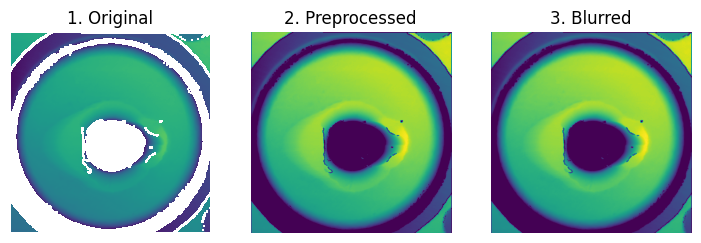

Breech-Face Impression Identification:


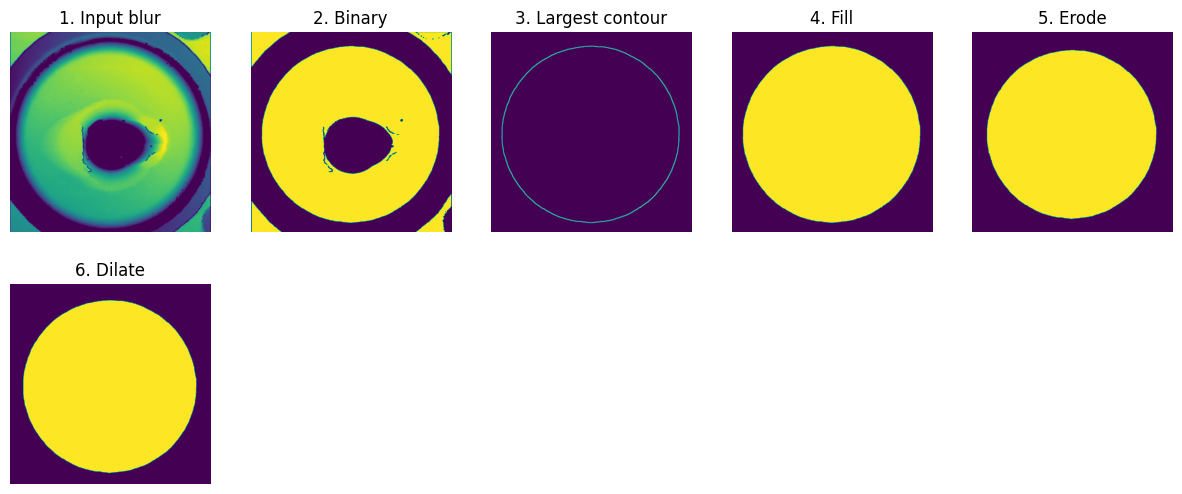

Identifying Elevated Region:


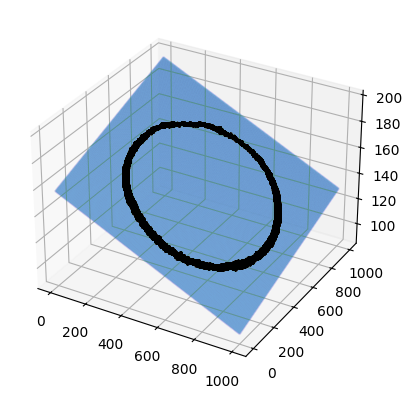

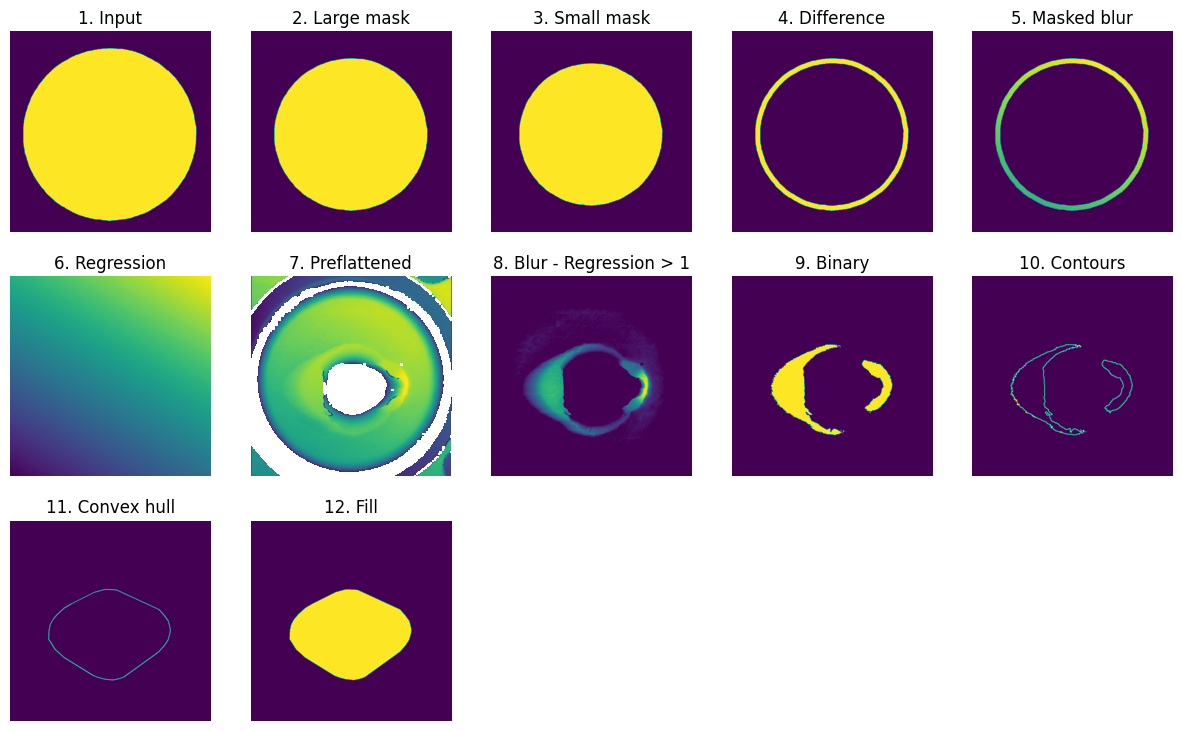

Isolate Firing Pin Impression:


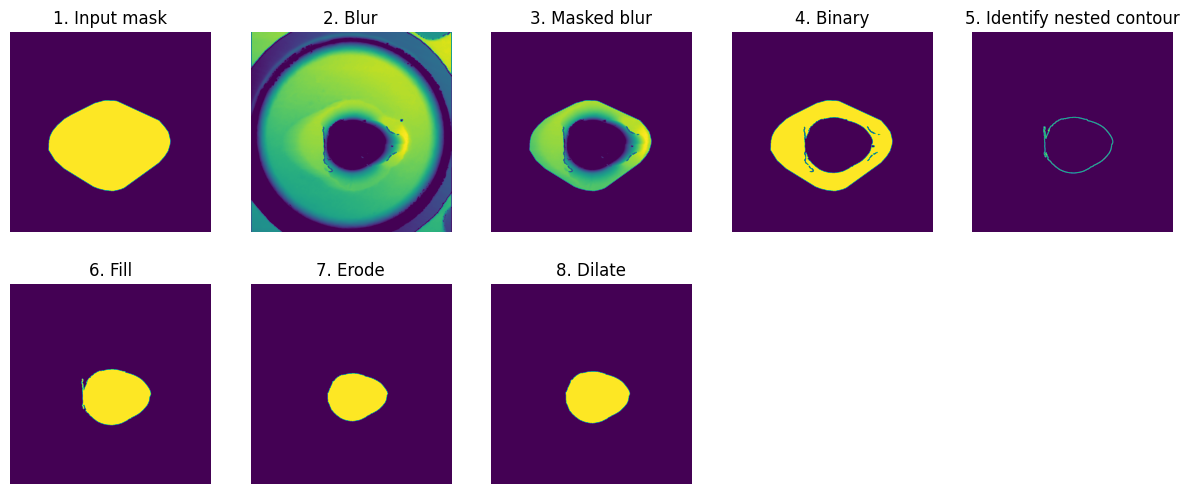

Refine Firing Pin Impression:


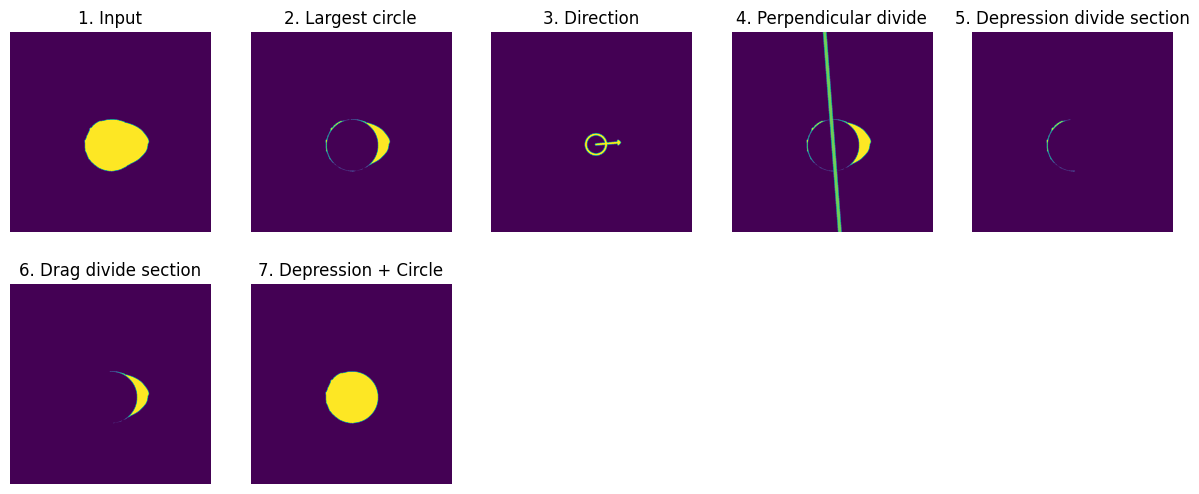

Identify Firing Pin Drag Region:


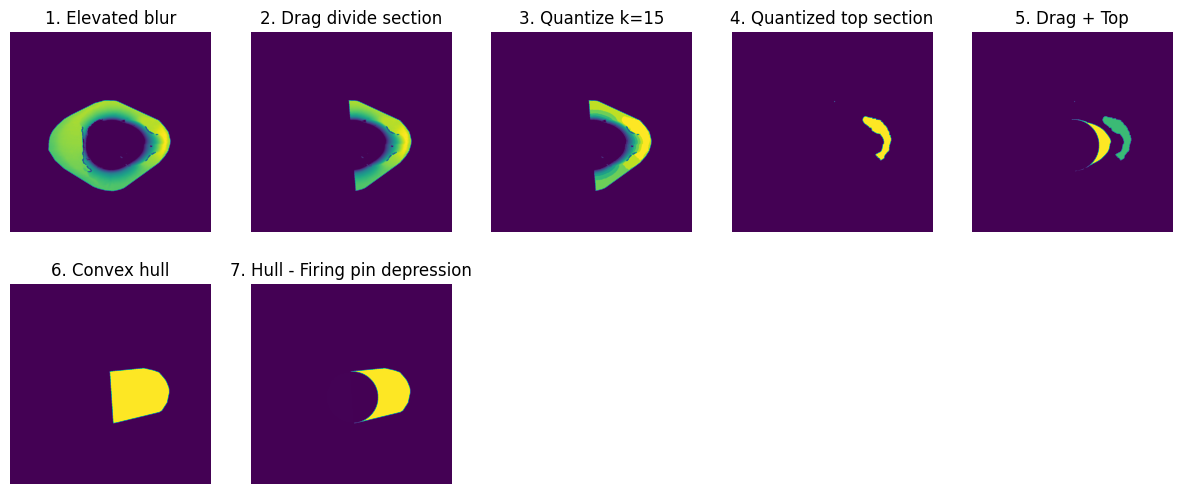

Determine Drag Direction:


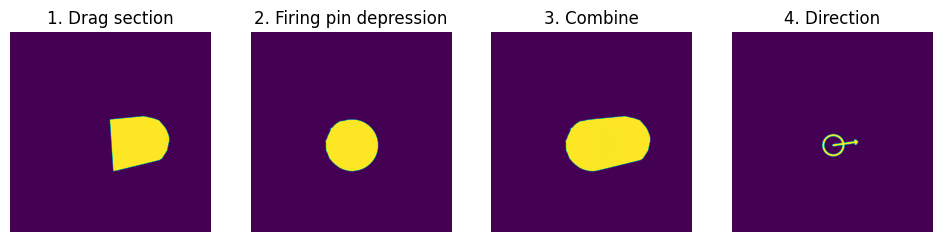

Draw Aperture Shear:


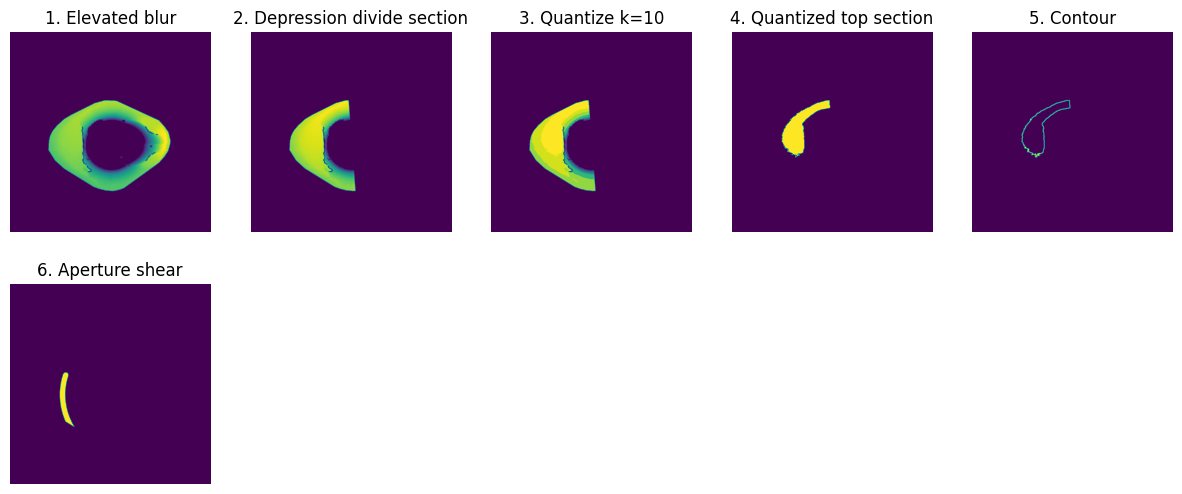

In [5]:
def prep(original):
    """
    Preprocesses and prepares the given image data.

    Parameters:
    - original (numpy.ndarray): The original image data.

    Returns:
    - numpy.ndarray: The blurred and preprocessed image data.
    """
    image = preprocess_image(df)
    blur = blur_image(image)

    plots = [
        (original, "Original"),
        (image, "Preprocessed"),
        (blur, "Blurred"),
    ]

    graph(plots)
    return blur


def identify_breechcircle(blur):
    """
    Identifies the general breech face impression outline in a blurred image.

    Parameters:
    - blur (numpy.ndarray): The input blurred image.

    Returns:
    - binary (numpy.ndarray): Binary image after thresholding.
    - dilate (numpy.ndarray): Breech face impression after morphological dilation.
    """
    binary = binarize_image(blur)
    outline, contours = find_contours(binary, get_largest=True)
    filled = fill_contours(contours)

    # Reduce noise
    erode = erode_image(filled)
    dilate = dilate_image(erode)

    plots = [
        (blur, "Input blur"),
        (binary, "Binary"),
        (outline, "Largest contour"),
        (filled, "Fill"),
        (erode, "Erode"),
        (dilate, "Dilate"),
    ]

    graph(plots)
    return binary, dilate


def identify_elevatedfiringpin(blur, breechcircle):
    """
    Identify an elevated firing pin impression region in an image.

    Parameters:
    - blur (numpy.ndarray): The input image with potential firing pin features.
    - breechcircle (numpy.ndarray): The image containing the circle indicating the breech
        face impression region

    Returns:
    - filled (numpy.ndarray): Image with filled convex hull outlining the elevated region.
    """
    # Perform two erosions followed by masking
    # To identify a small circle
    large_c = erode_image(breechcircle, (100, 100))
    small_c = erode_image(breechcircle, (150, 150))
    masked = mask_image(large_c, ~small_c)
    blur_masked = mask_image(blur, masked)

    # Flatten image
    plane = get_regression(blur_masked)
    blur = blur.astype(np.float32)
    blur[blur == 0] = np.nan

    # Map <= 1 to 0
    flattened = blur - plane

    elevated = flattened.copy()
    elevated[elevated <= 1] = 0
    elevated[np.isnan(elevated)] = 0
    elevated = elevated.astype(np.uint8)

    # Binary
    binary = binarize_image(elevated)

    # Convex hull
    outline, contours = find_contours(binary)
    combined = np.vstack(contours)
    hull = cv2.convexHull(combined)
    hull_outline = blank_reference.copy()
    cv2.drawContours(hull_outline, [hull], -1, (255, 0, 0), 2)

    # Fill
    filled = fill_contours([hull])

    plots = [
        (breechcircle, "Input"),
        (large_c, "Large mask"),
        (small_c, "Small mask"),
        (masked, "Difference"),
        (blur_masked, "Masked blur"),
        (plane, "Regression"),
        (blur, "Preflattened"),
        (elevated, "Blur - Regression > 1"),
        (binary, "Binary"),
        (outline, "Contours"),
        (hull_outline, "Convex hull"),
        (filled, "Fill"),
    ]
    graph(plots)
    return filled


def identify_firingpin(blur, elevated):
    """
    Identify the general firing pin impression region in an image.

    Parameters:
    - blur (numpy.ndarray): The input image.
    - elevated (numpy.ndarray): Mask defining the region of interest.

    Returns:
    - masked (numpy.ndarray): Masked image highlighting the elevated region.
    - dilate (numpy.ndarray): General firing pin impression region.
    """
    # Mask elevated region
    masked = mask_image(blur, elevated)

    # Threshold
    thresh = binarize_image(masked)

    # Find nested contour and fill
    o1, c1 = find_contours(
        thresh, np.prod(binary.shape) * 0.01, keep_nested=True, get_largest=True
    )
    filled = fill_contours(c1)

    # Reduce noise
    erode = erode_image(filled)
    dilate = dilate_image(erode)

    plots = [
        (elevated, "Input mask"),
        (blur, "Blur"),
        (masked, "Masked blur"),
        (thresh, "Binary"),
        (o1, "Identify nested contour"),
        (filled, "Fill"),
        (erode, "Erode"),
        (dilate, "Dilate"),
    ]

    graph(plots)

    return masked, dilate


def identify_drag_direction(firingpin, alt_centroid=None):
    """
    Identify the centroid and orientation angle of a given firing pin impression
    contour, and draw a direction line.

    Parameters:
    - firingpin (numpy.ndarray): Binary image representing the firing pin impression.
    - alt_centroid (tuple, optional): Alternative centroid coordinates. If provided,
      the direction line will be drawn from this centroid. Default is None.

    Returns:
    - centroid (tuple): Coordinates of the centroid of the firing pin contour.
    - theta (float): Orientation angle of the firing pin contour.
    - direction (numpy.ndarray): Image with a drawn direction line based on the centroid
      or the alternative centroid if provided.
    """
    _, contour = find_contours(firingpin, get_largest=True)
    centroid, theta = get_contour_details(contour[0])

    if alt_centroid:
        direction = draw_direction(alt_centroid, theta)
    else:
        direction = draw_direction(centroid, theta)
    return centroid, theta, direction


def refine_and_misc(elevated_blur, firingpin):
    """
    Refine the firing pin impression image region by identifying its various
    sections, including depression, drag, and aperture shear.

    Parameters:
    - elevated_blur (numpy.ndarray): The elevated blur image.
    - firingpin (numpy.ndarray): The firing pin impression image.

    Returns:
    - complete_firingpin (numpy.ndarray): Refined firing pin impression image.
    - complete_drag (numpy.ndarray): Refined drag section image.
    - direction (numpy.ndarray): Firing pin drag direction image.
    - shear (numpy.ndarray): Aperture shear image.
    """
    centroid, theta, direction_old = identify_drag_direction(firingpin)
    dist_map = cv2.distanceTransform(firingpin, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
    _, radius, _, circ_center = cv2.minMaxLoc(dist_map)

    largest_inner_circle = cv2.circle(
        firingpin.copy(), circ_center, int(radius), 0, cv2.FILLED
    )

    p1 = get_point(circ_center, theta + np.radians(90), 1000)
    p2 = get_point(circ_center, theta - np.radians(90), 1000)
    division_line = cv2.line(largest_inner_circle.copy(), p1, p2, 200, 15)

    # Get firing pin depression section
    p3 = get_point(p1, theta, 1000)
    p4 = get_point(p2, theta, 1000)
    points = np.array([p1, p3, p4, p2], dtype=np.int32)

    pin_section = cv2.fillPoly(
        largest_inner_circle.copy(),
        [points],
        color=0,
    )

    elevated_masked_body = cv2.fillPoly(
        elevated_blur.copy(),
        [points],
        color=0,
    )

    # Get firing pin drag section
    theta_inverse = theta - np.radians(180)
    p3 = get_point(p1, theta_inverse, 1000)
    p4 = get_point(p2, theta_inverse, 1000)
    points = np.array([p1, p3, p4, p2], dtype=np.int32)

    drag_section = cv2.fillPoly(
        largest_inner_circle.copy(),
        [points],
        color=0,
    )

    _, drag_section_contours = find_contours(drag_section)

    # Combine depression + circle
    complete_firingpin = cv2.circle(
        pin_section.copy(), circ_center, int(radius), 255, cv2.FILLED
    )

    # Identify remaining drag section
    elevated_masked_drag = cv2.fillPoly(
        elevated_blur.copy(),
        [points],
        color=0,
    )

    quantized_drag = quantize(elevated_masked_drag, 15)

    top_section = quantized_drag.copy()
    for value in np.unique(quantized_drag)[:-1]:
        top_section[top_section == value] = 0

    o1, c1 = find_contours(top_section)
    relevant_contours = []
    for contour in c1:
        if find_furthest_point_based_on_angle(contour, centroid, theta, threshold=5):
            relevant_contours.append(contour)

    combined = np.vstack(drag_section_contours + relevant_contours)
    hull = cv2.convexHull(combined)
    hull_outline = blank_reference.copy()
    cv2.drawContours(hull_outline, [hull], -1, 255, cv2.FILLED)

    # Subtract complete pin by drag
    complete_drag = hull_outline - complete_firingpin

    # Redefine direction
    centroid, theta, direction = identify_drag_direction(
        hull_outline + complete_firingpin, circ_center
    )
    theta_inverse = theta - np.radians(180)

    # Identify aperture shear
    quantized_body = quantize(elevated_masked_body, 10)

    top_body = quantized_body.copy()
    for value in np.unique(quantized_body)[:-1]:
        top_body[top_body == value] = 0

    o2, c2 = find_contours(top_body)

    for c in c2:
        furthest_point = find_furthest_point_based_on_angle(
            c, centroid, theta_inverse, threshold=3
        )
        if furthest_point:
            break

    dist = calculate_distance(centroid, furthest_point)
    shear = blank_reference.copy()
    cv2.ellipse(
        shear,
        centroid,
        (int(dist), int(dist)),
        0,
        int(np.degrees(theta_inverse) + 25),
        int(np.degrees(theta_inverse) - 25),
        255,
        25,
    )
    shear = mask_image(shear, elevated)

    plots = [
        (firingpin, "Input"),
        (largest_inner_circle, "Largest circle"),
        (direction_old, "Direction"),
        (division_line, "Perpendicular divide"),
        (pin_section, "Depression divide section"),
        (drag_section, "Drag divide section"),
        (complete_firingpin, "Depression + Circle"),
    ]
    print("Refine Firing Pin Impression:")
    graph(plots)

    plots = [
        (elevated_blur, "Elevated blur"),
        (elevated_masked_drag, "Drag divide section"),
        (quantized_drag, "Quantize k=15"),
        (top_section, "Quantized top section"),
        (top_section + drag_section, "Drag + Top"),
        (hull_outline, "Convex hull"),
        (complete_drag, "Hull - Firing pin depression"),
    ]
    print("Identify Firing Pin Drag Region:")
    graph(plots)

    plots = [
        (hull_outline, "Drag section"),
        (complete_firingpin, "Firing pin depression"),
        (hull_outline + complete_firingpin, "Combine"),
        (direction, "Direction"),
    ]
    print("Determine Drag Direction:")
    graph(plots)

    plots = [
        (elevated_blur, "Elevated blur"),
        (elevated_masked_body, "Depression divide section"),
        (quantized_body, "Quantize k=10"),
        (top_body, "Quantized top section"),
        (o2, "Contour"),
        (shear, "Aperture shear"),
    ]
    print("Draw Aperture Shear:")
    graph(plots)

    return complete_firingpin, complete_drag, direction, shear


print("Data Preparation:")
blur = prep(df)
blank_reference = np.zeros_like(blur)
print("Breech-Face Impression Identification:")
binary, breechface = identify_breechcircle(blur)
print("Identifying Elevated Region:")
elevated = identify_elevatedfiringpin(blur, breechface)
print("Isolate Firing Pin Impression:")
elevated_blur, firingpin = identify_firingpin(blur, elevated)
complete_firingpin, complete_drag, direction, shear = refine_and_misc(
    elevated_blur, firingpin
)

## Prepare images and display combined results


In [6]:
def prepare_objects(objects):
    """
    Preprocesses a list of binary images by iteratively applying masks to each
    image based on the complement of the subsequent images in the list.

    Parameters:
    - objects (list): A list of binary images to be processed.

    Returns:
    - list: A list of processed binary images.
    """
    prepared_objs = []
    for i, obj in enumerate(objects):
        obj = binarize_image(obj)
        for remaining_obj in objects[i + 1 :]:
            remaining_obj = binarize_image(remaining_obj)
            obj = mask_image(obj, ~remaining_obj)

        prepared_objs.append(obj)

    return prepared_objs


dilated_elevate = dilate_image(elevated)
prepared_objs = prepare_objects(
    [
        breechface,
        dilated_elevate,
        complete_firingpin,
        complete_drag,
        shear,
        direction,
    ]
)
# Remove the second element (index 1) from the prepared_objs list
_ = prepared_objs.pop(1)

(<Axes: >,
 (-0.5, 999.5, 999.5, -0.5))

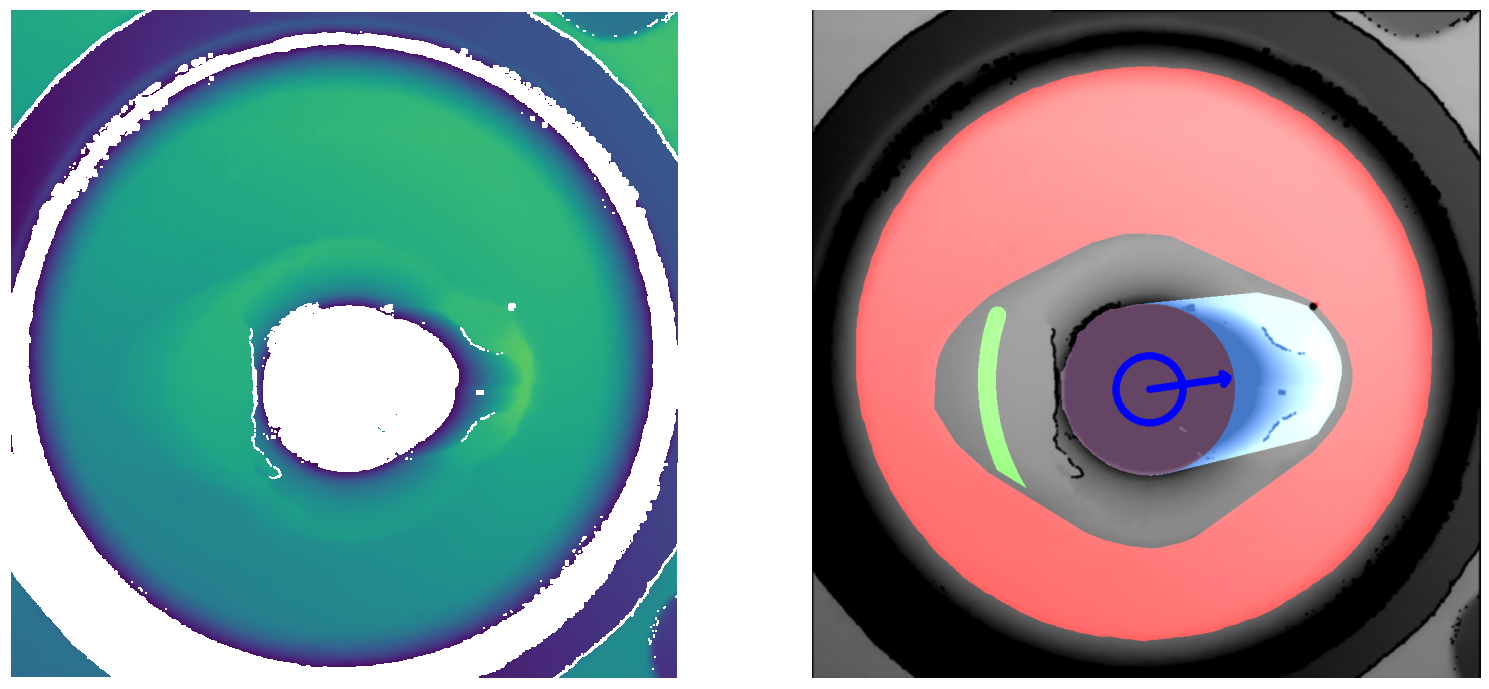

In [7]:
def combine_images(blur, images, color_list):
    """
    Combines a blurred background image with a list of color-coded images.

    Parameters:
    - blur (numpy.ndarray): Blurred background image.
    - images (list): List of binary images to be combined with the blurred background.
    - color_list (list): List of RGB tuples specifying colors for each binary image.

    Returns:
    - numpy.ndarray: Combined image with color-coded regions.
    """
    canvas = cv2.merge([blur, blur, blur])
    for i, test_im in enumerate(images):
        color = color_list[i]

        r = test_im.copy()
        r[r == 255] = color[0]
        g = test_im.copy()
        g[g == 255] = color[1]
        b = test_im.copy()
        b[b == 255] = color[2]

        rgba_image = cv2.merge([r, g, b])

        # Add the current image to the canvas
        canvas = cv2.addWeighted(canvas, 1, rgba_image, 1, 0)

    return canvas


color_list = [
    (255, 0, 0),  # Breechface
    (100, 70, 100),  # Firing pin
    (70, 120, 200),  # Drag
    (23, 255, 0),  # Shear
    (0, 0, 255),  # Direction
]


final = combine_images(blur, prepared_objs, color_list)

# Display the original and combined images
plt.figure(figsize=(50, 50))
plt.subplot(151), plt.imshow(df), plt.axis("off")
plt.subplot(152), plt.imshow(final), plt.axis("off")